### Get Data

In [27]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip

--2020-05-31 12:37:03--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  33.1MB/s    in 0.9s    

2020-05-31 12:37:04 (33.1 MB/s) - ‘text8.zip’ saved [31344016/31344016]



In [28]:
!unzip "/content/text8.zip"

Archive:  /content/text8.zip
  inflating: text8                   


In [0]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
import torch
from torch import nn, optim

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Loading Data

In [32]:
with open("/content/text8") as f:
    TEXT = f.read()

TEXT[:100]

' anarchism originated as a term of abuse first used against early working class radicals including t'

### Pre-processing

In [0]:
def pre_process_text(text):
    """
    Replace punctuation with tokens so we can use them in our model
    Remove all words with  5 or fewer occurences
    """
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]
    return trimmed_words

In [34]:
words = pre_process_text(TEXT)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [35]:
total_words = len(words)
unique_words = len(set(words))
print("Total words : ", total_words)
print("Unique words : ", unique_words)

Total words :  16680599
Unique words :  63641


In [0]:
def create_lookup_tables(words):
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    return vocab_to_int, int_to_vocab

In [0]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

### Subsampling

In [38]:
word_count = Counter(int_words)
list(word_count.items())[0]

(5233, 303)

In [39]:
threshold = 1e-5
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_count.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_count}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
print(train_words[:20])

[5233, 3080, 3133, 10571, 27349, 15067, 58112, 3580, 10712, 214, 686, 7088, 5233, 320, 44611, 10, 8983, 4147, 6437, 1137]


### Batches

In [0]:
def get_target(words, idx, window_size=5):
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    return list(target_words)

In [41]:
# test-case

int_text = [i for i in range(10)]
print('Input: ', int_text)

idx = 5
target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [3, 4, 6, 7]


In [0]:
def get_batches(words, batch_size, window_size=5):
    n_batches = len(words) // batch_size
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for index in range(len(batch)):
            batch_x = batch[index]
            batch_y = get_target(batch, index, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

### Validation

In [0]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    embed_vectors = embedding.weight
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
    return valid_examples, similarities

### SkipGram Model

In [0]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist, batch_size * n_samples, replacement=True)
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        return noise_vectors

In [0]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        batch_size, embed_size = input_vectors.shape
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)
        return -(out_loss + noise_loss).mean()

### Training

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)
        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/5
Loss:  6.854457378387451
most | mankind, responsive, erroneous, fleshy, and
this | of, by, is, gardens, one
when | tricked, after, pair, cleric, describe
however | buckminster, an, onion, thomas, well
two | the, zero, of, wet, one
of | the, one, is, and, a
is | of, the, in, four, nine
will | glomerulosa, withdrew, rendezvous, nocturnal, evasion
magazine | impressions, adult, assessment, compassion, mimics
consists | completely, cylinders, latitudes, water, devout
animals | geocities, code, verse, anglicized, miraculous
mathematics | father, hampshire, gallery, interacting, esther
older | illegal, dubbed, corvette, voyage, pardon
pressure | wallonia, supplied, extremes, rttemberg, prohibit
additional | shrines, pandavas, sand, hulls, munich
dr | while, unchanged, volcanic, seq, cisc
...

Epoch: 1/5
Loss:  5.31113338470459
a | and, the, of, in, to
are | and, to, in, a, the
one | the, of, nine, and, in
between | of, a, as, to, and
for | and, the, in, a, of
an | for, and, to, in

### Visualizing the word vectors

In [0]:
emb = model.in_embed.weight.to('cpu').data.numpy()

In [0]:
viz_words = 300
tsne = TSNE()
emb_tsne = tsne.fit_transform(emb[:viz_words, :])

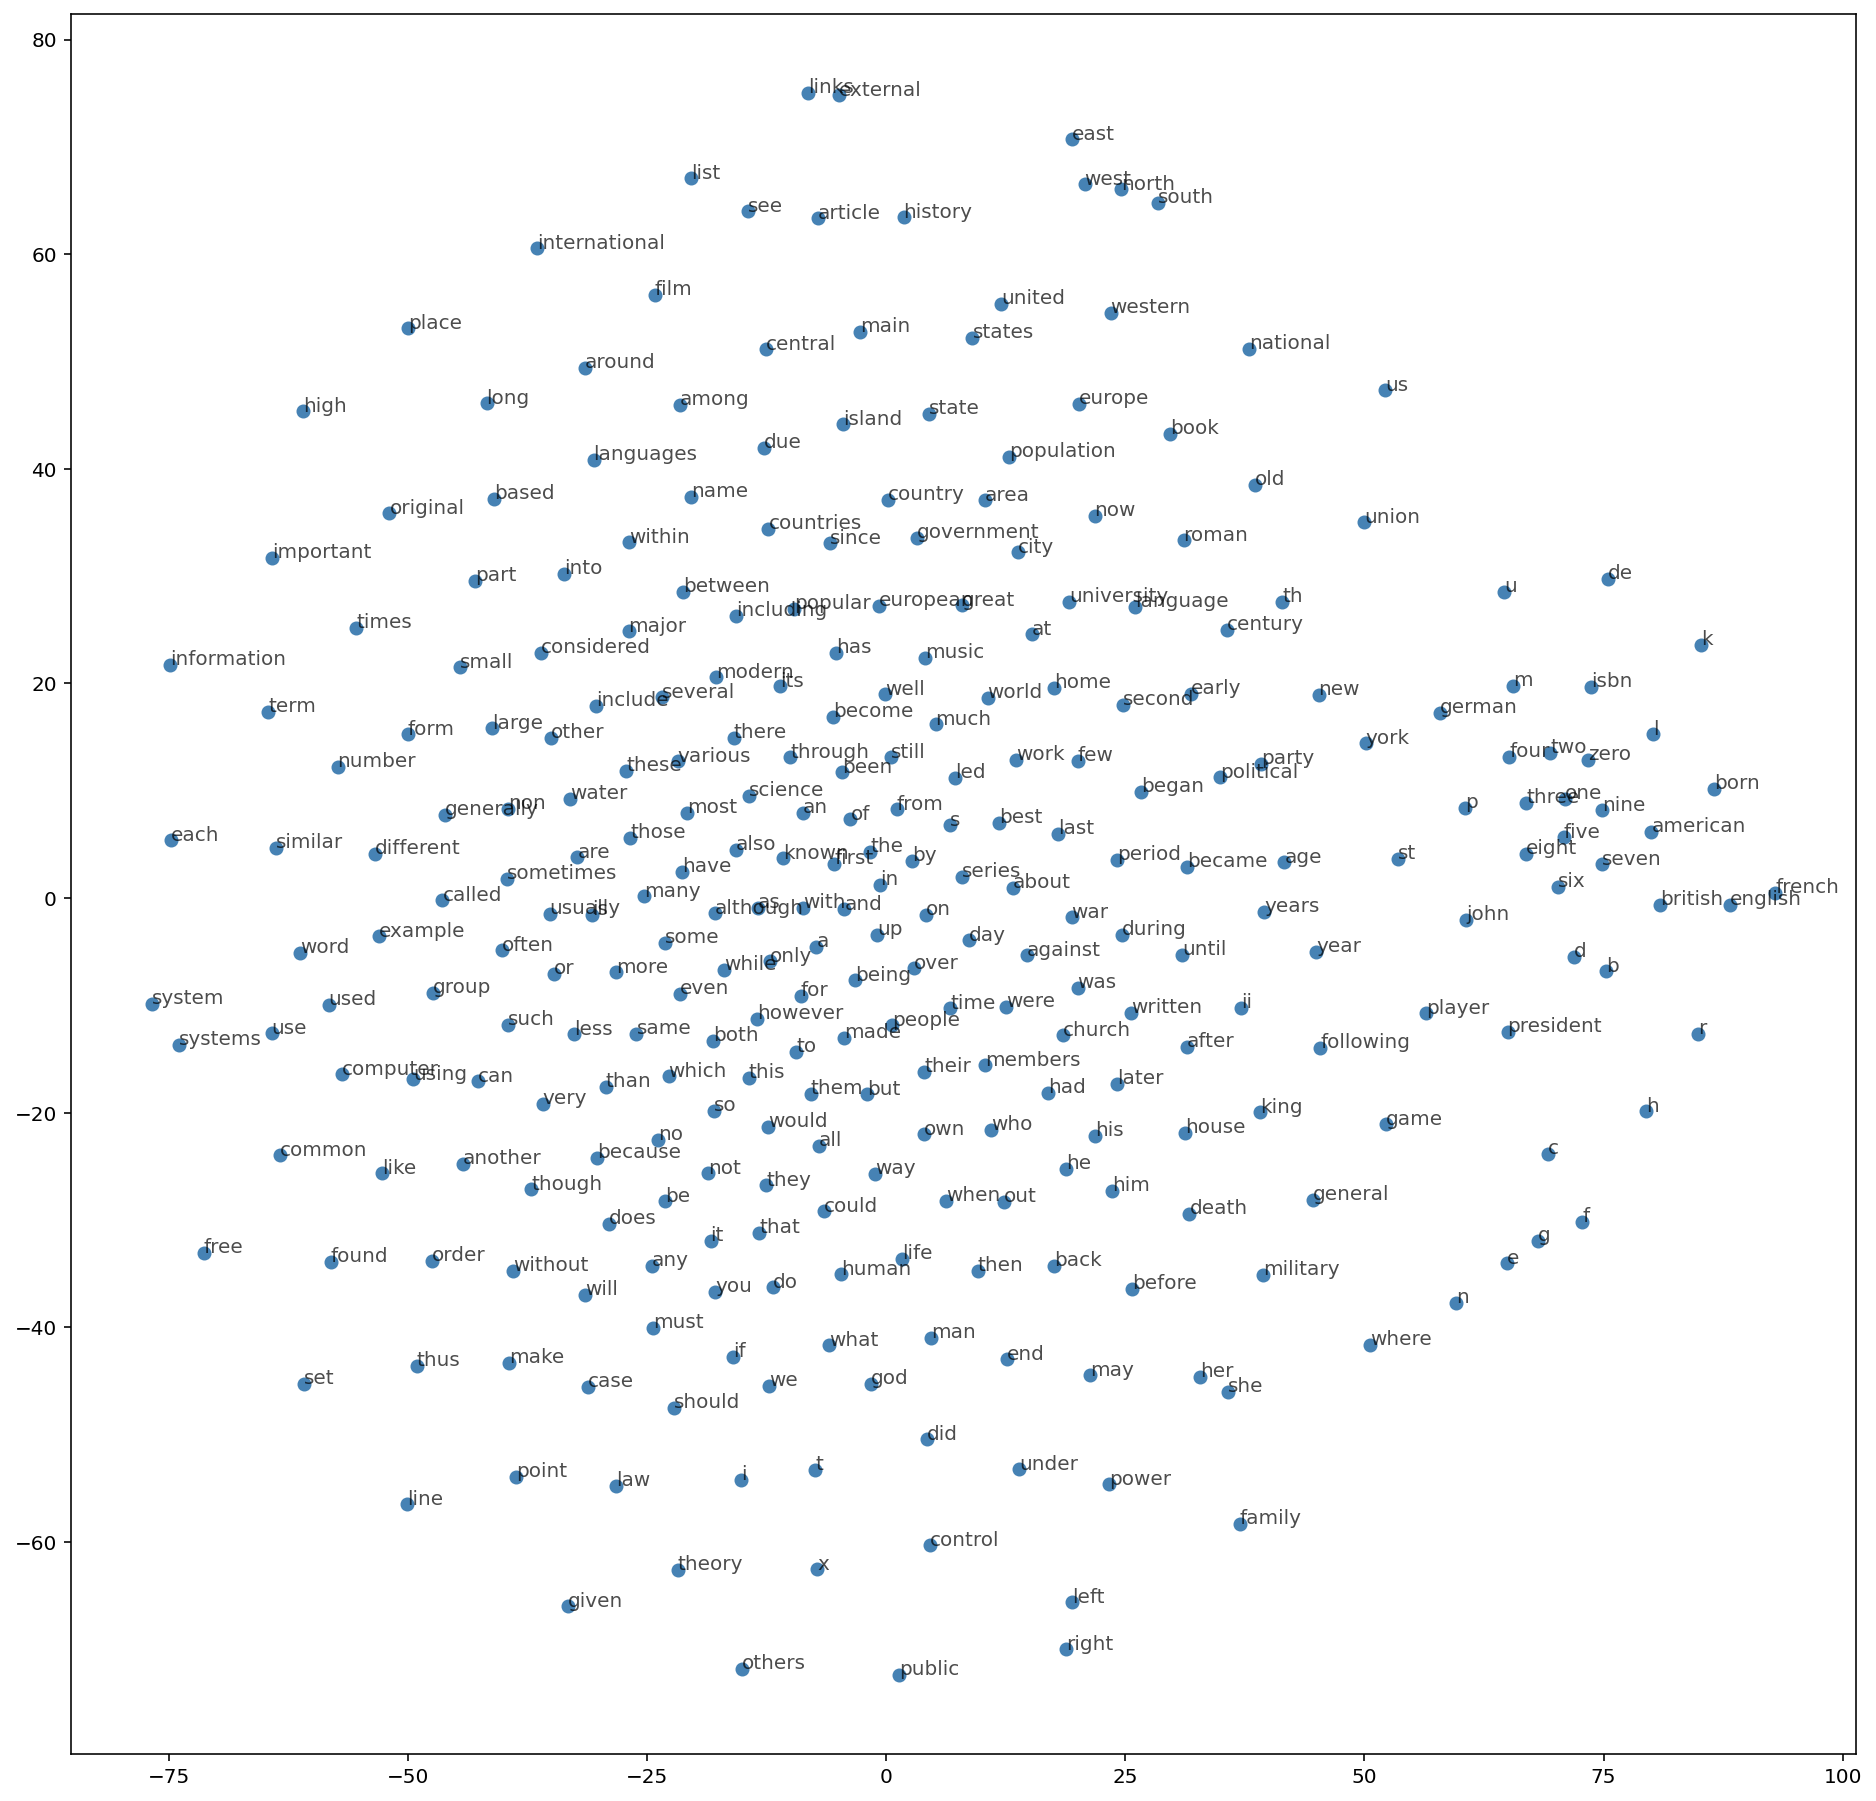

In [55]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*emb_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (emb_tsne[idx, 0], emb_tsne[idx, 1]), alpha=0.7)